# Automated Text summarization for dialogues with Transformer models

## Specialisation project 1 (VT1)

### Master of Science in Engineering
### Zurich University of Applied Sciences

### Author: Loran Avci (avci@zhaw.ch)

### Advisor: Mark Cieliebak (ciel@zhaw.ch)

### 31.01.2021

# 1. Preprocessing data

The first section only serves to clean up the data. Since the data used here is Kaggle data, it is already in a proper format. The dataset should have at least the columns 'speaker', 'minute' and 'text' or similar columns with the given column names. 

- data source : https://www.kaggle.com/headsortails/us-election-2020-presidential-debates?select=us_election_2020_vice_presidential_debate.csv

In [1]:
# import libraries
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
import glob
import re
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tag import pos_tag
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

import rouge
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models

# options
pd.options.display.max_colwidth =10000

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
C:\Users\avci\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
def preprocess_data(path, train_data):
    """
    arguments: {path: path to data location
                train_data: special treatment for traindata used in this project}
    - loads data into pandas df
    - removes different kind of punctution,empty strings, nan etc. from text data
    returns: {df: cleaned data frame}
    """
    
    # Data import:  adjust this parameter to you own directory
    df = pd.read_csv(path)
    
    if train_data:
        df.speaker[df['speaker'] == 'Kamala Harris '] = 'Kamala Harris'

    #preprocessing
    df = df.replace(np.nan, '', regex=True)
    for i,text in enumerate(df['text']):
        text = text.replace('…', '')
        #text = text.replace('’', '')
        #text = text.replace(',', '')
        #text = text.replace("'", "")
        #text = text.replace('"', "")
        #text = text.replace('-', "")
        #text = text.replace('—', "")
        #text = text.replace('—', "")
        df.at[i, 'clean'] = text
        
    for i, text in enumerate(df['clean']):
        t = re.sub('[[^>].*]', ' ', text)
        df.at[i, 'clean'] = t

    return df

#df = preprocess_data(path =r"all_debates\us_election_2020_vice_presidential_debate.csv" , train_data = True)
df = preprocess_data(path =r"all_debates\us_election_2020_2nd_presidential_debate.csv" , train_data = False)



C:\Users\avci\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Possible nested set at position 1


# 2. Descriptive Statistics and Visualization

The second section is used to visualise the data, especially the characters, tokens and sentence length in the individual observations. Furthermore, the threshold values are defined in this section, which are decisive for the rest of the code.


median: #c = 66, #t = 12, #s = 2
mean: #c = 195, #t = 35, #s = 3
90% quantile: #c = 577, #t = 104, #s = 8


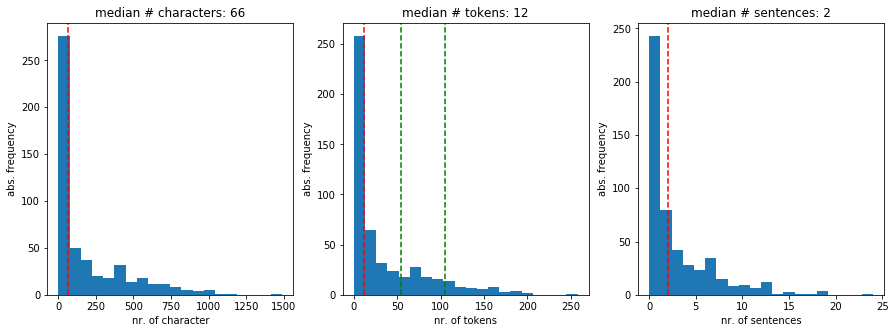

Thresholds:  105.0 54.0


In [3]:
def plot_distribution(column):
    
    """
    arguments : {column: column in dataframe which should be processed for descriptive statistics e.g. cleaned text} 
    - Descriptive statistics: median, mean and 90% quantile for character length, token length and sentence length 
    - Plot distribution of descriptive statistics
    returns : { mon_threshold : monologue threshold (e.g. 90% quantile of token len) , 
                deb_threshold : statement threshold (e.g. 70% quantile of token len)}
    """
    chars = []
    tokens = []
    sents = []
    for i in column:
        chars.append(len(i))
        tokens.append(len(i.split()))
        sents.append(len(nltk.sent_tokenize(i)))
        
    print("median: #c = %i, #t = %i, #s = %i" % (np.median(chars),np.median(tokens),np.median(sents)))
    print("mean: #c = %i, #t = %i, #s = %i" %(np.mean(chars),np.mean(tokens),np.mean(sents)))
    print("90%% quantile: #c = %i, #t = %i, #s = %i" %(np.quantile(chars, q=0.90), np.quantile(tokens, q=0.90), np.quantile(sents, q=0.90)))
    
    mon_threshold = np.quantile(tokens, q=0.90)
    deb_threshold = np.quantile(tokens, q=0.75)

    
    plt.figure(figsize=(15,5))
    plt.subplot(1, 3, 1)
    plt.title('median # characters: %i' %np.median(chars))
    plt.hist(chars,bins=20)
    plt.axvline(np.median(chars),color = 'r',linestyle='--', label = 'median')
    plt.xlabel("nr. of character")
    plt.ylabel("abs. frequency")
    plt.subplot(1, 3, 2)
    plt.title('median # tokens: %i' %np.median(tokens))
    plt.hist(tokens,bins=20)
    plt.axvline(np.median(tokens),color = 'r',linestyle='--', label = 'median')
    plt.axvline(np.quantile(tokens, q=0.90),color = 'g',linestyle='--', label = 'median')
    plt.axvline(np.quantile(tokens, q=0.75),color = 'g',linestyle='--', label = 'median')
    plt.xlabel("nr. of tokens")
    plt.ylabel("abs. frequency")
    plt.subplot(1, 3, 3)
    plt.title('median # sentences: %i' %np.median(sents))
    plt.hist(sents,bins=20)
    plt.axvline(np.median(sents),color = 'r',linestyle='--', label = 'median')
    plt.xlabel("nr. of sentences")
    plt.ylabel("abs. frequency")
    plt.show();
    
    print("Thresholds: ",round(mon_threshold), round(deb_threshold))
    return round(mon_threshold), round(deb_threshold)
    
mon_threshold , deb_threshold = plot_distribution(df['clean'])

In [4]:
def get_len_type(column,deb_threshold, mon_threshold ):
    """
    arguments: {column : column in dataframe which should be processed e.g. cleaned text
                mon_threshold, deb_treshhold : values for monologue / statement threshold  }
    - creating categorical variable based on quantiles of token length
    return: {}
    """
    lens = []
    for text in column:
        lens.append(len(text.split()))
    df['lens'] = lens 
    df.loc[df['lens'] >= mon_threshold, 'len_type'] = '<monologue>'
    df.loc[(df['lens'] < mon_threshold) & (df['lens'] >= deb_threshold) , 'len_type'] = '<statement>'# '<debate>'
    df.loc[df['lens'] < deb_threshold , 'len_type'] = '<discussion>'
    
get_len_type(df['clean'], deb_threshold, mon_threshold)

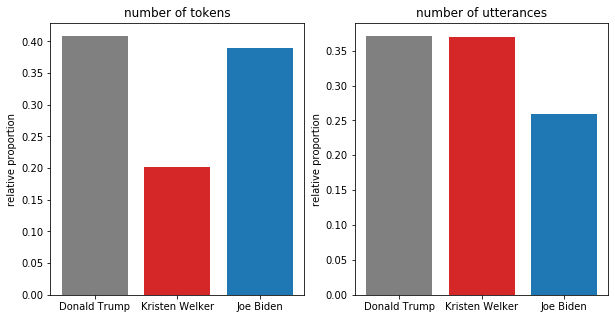

Text(0.5, 1.0, 'dialogue types')

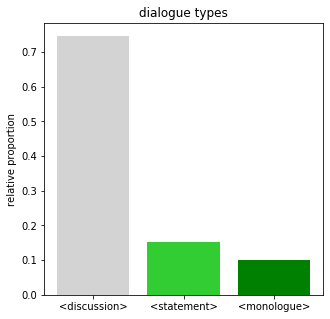

In [5]:

# alternative plots for speaker distributiion

toks = []
i = pd.DataFrame(df['speaker'].value_counts(normalize=True)).index
x = pd.DataFrame(df['speaker'].value_counts(normalize=True))['speaker'].values
toks.append([sum(df[df['speaker'] == i[0]]['lens']) / sum(df['lens']),sum(df[df['speaker'] == i[1]]['lens']) /sum(df['lens']), sum(df[df['speaker'] == i[2]]['lens']) /sum(df['lens'])])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(i, toks[0], color=('gray', 'tab:red','tab:blue'))
plt.ylabel('relative proportion')
plt.title('number of tokens')
plt.subplot(1,2,2)
plt.bar(i,x, color=('gray', 'tab:red','tab:blue'))
plt.ylabel('relative proportion')
plt.title('number of utterances')
plt.show()

plt.figure(figsize=(5,5))
i = pd.DataFrame(df['len_type'].value_counts(normalize=True)).index
x = pd.DataFrame(df['len_type'].value_counts(normalize=True))['len_type'].values
plt.bar(i,x, color=('lightgray', 'limegreen','green'))
plt.ylabel('relative proportion')
plt.title('dialogue types')


# 3. Text Generation  with T5


In this section the pre-trained T5 models are loaded. The given function then summarises the utterances differently according to certain threshold values. Apart from T5 models, other models can also be applied and the hyperparameters of the models, such as the minimum or maximum length of the summaries, can be changed. 

In [6]:
# laod pretrained large model
modelT5 = T5ForConditionalGeneration.from_pretrained('t5-large')
tokenizerT5 = T5Tokenizer.from_pretrained('t5-large')
# load pretrained small model
modelT5s = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizerT5s = T5Tokenizer.from_pretrained('t5-small')
# load pretrained small model
modelT5b = T5ForConditionalGeneration.from_pretrained('t5-base')
tokenizerT5b = T5Tokenizer.from_pretrained('t5-base')

# declare device
device = torch.device('cpu')

In [7]:
def generate_summary(input_text, deb_threshold, mon_threshold):
    """
    arguments : { input_text: column with text that should be summarized
                  mon_threshold, deb_treshhold : values for monologue / statement threshold  }
    - generates T5 summary based on token length
    - creates an <ignored> token for utterances shorter than deb_threshold
    return : {list of summary for each text}
    """
    start=datetime.now() # for processing time surveillance
    
    summariesT5 = []
    for t in input_text:
        tok_len = len(t.split())
            
        if (tok_len >= deb_threshold): #74 in train data
            t5_prepared_Text = "summarize: "+ t
            
            if (tok_len >= mon_threshold): #147 in train data
                min_len = round(0.2 * tok_len) # can be modified
                max_len = round(0.4 * tok_len) # can be modified
                
                #encoder
                tokenized_text = tokenizerT5s.encode(t5_prepared_Text, return_tensors="pt").to(device)
    
                #summmarize 
                summary_ids = modelT5s.generate(tokenized_text,
                                            num_beams=32,
                                            no_repeat_ngram_size=3,#  If set to int > 0, all ngrams of that size can only occur once.
                                            min_length=min_len,
                                            max_length= max_len,
                                            early_stopping=True)
                #decoder
                output = tokenizerT5s.decode(summary_ids[0], skip_special_tokens=True)
                summariesT5.append(output)
                            
            else: # if tok_len > deb_threshold and < mon_threshold
                #encoder
                tokenized_text = tokenizerT5s.encode(t5_prepared_Text, return_tensors="pt").to(device)
    
                #summmarize 
                summary_ids = modelT5s.generate(tokenized_text,
                                            num_beams=32,
                                            no_repeat_ngram_size=2,#  If set to int > 0, all ngrams of that size can only occur once.
                                            min_length= 5  , # 7, min_len,
                                            max_length= 15 , # 15, max_len,
                                            early_stopping=True)
                #decoder
                output = tokenizerT5s.decode(summary_ids[0], skip_special_tokens=True)
                summariesT5.append(output)
            
        else:
            summariesT5.append('<ignored>')
    
    print(datetime.now()-start)
    return summariesT5

sums = generate_summary(df['clean'], deb_threshold, mon_threshold )

df['sumt5'] = sums

0:13:24.905812


# 4. Key Word Extraction with TF-IDF 

This section is dedicated to the allocation of individual discussions into blocks. Then, for the blocks and utterances that have the type monologue or statement, the most important key words are extracted using TF-IDF and merged back with the original data set. 

In [8]:
def make_discussion_nests(df, deb_threshold):
    """
    arguments: {df: dataframe containing info for text an length of discussions
                deb_threshold: threshold for length of statements}
    - nests utterances with len type == discussion to nests with len < deb_threshold
    returns {disc: df containing discussion nests and coresponding indizes of utterances}
    """
    # select only discussions
    dfdis = df[df['len_type']== '<discussion>']
    dfdis = dfdis[['speaker', 'minute', 'text', 'lens']] # text - clean
    dfdis['index1'] = dfdis.index
    block = []
    nest=[]
    delta_i = [0]
    indx = []
    indx_block =[]
    
    # make nests of utterances with <discussion> as len type
    for i, lens, clean in zip(dfdis['index1'],dfdis['lens'], dfdis['text']):
        delta_i.append(lens)
        if sum(delta_i) < deb_threshold: # adjustable threshhold under length of '<statement>'#
            block.append(clean)
            indx_block.append(i)
        else:
            delta_i = [lens]
            nest.append(block)
            block = [clean]        
            indx.append(indx_block)
            indx_block = [i]
            
    joined_nest = []
    for i in nest:
        txt = ' - '.join(i)
        joined_nest.append(txt)
        
    disc = pd.DataFrame(joined_nest,columns=['discussion'])
    # compute length and indexes for discussion nests
    lens = []
    for text in disc['discussion']:
        lens.append(len(text.split()))
    disc['lens'] = lens 
    disc['indx'] = indx
    
    return disc
    
disc = make_discussion_nests(df, deb_threshold)

# prepare data for monologue keyword extraction
disc_mon_deb = df[df['len_type'] != '<discussion>']
disc_mon_deb = disc_mon_deb[['speaker', 'minute', 'text', 'lens', 'len_type']]
disc_mon_deb.columns = ['speaker', 'minute', 'discussion', 'lens', 'len_type']
disc_mon_deb['indx'] = disc_mon_deb.index

In [9]:
def get_key_words(disc, n_key_words, mon_deb):
    """
    arguments : {disc: df containing discussion nests and coresponding indizes of utterances
                 n_key_words: number of key words that should be extracted for each nest}
    - extracts n_key_words for each discussion block using tfidf 
    - filter out only nouns (still buggy)
    returns : {disc: df from input with added keywords}
    """
    #disc['clean']= disc['discussion'].map(lambda x: re.sub('[,\.!?]', '', x))
    
    disc['clean'] = disc['discussion'].map(lambda x: x.lower())
    disc['clean'] = disc['clean'].str.split()
    stop = stopwords.words('english')
    disc['clean'] = disc['clean'].apply(lambda x: [item for item in x if item not in stop])
    disc['clean'] = disc['clean'].map(lambda x: " ".join(x))
    disc.reset_index()
    disc = disc[disc['clean'].notna()]
    
    noun = []
    for text in disc['clean']:
        toks = text.split()
        nouns = [word for (word, pos) in nltk.pos_tag(toks) if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')] 
        noun.append(nouns)
        
    disc['noun'] = noun
    disc['noun'] = disc['noun'].map(lambda x: " ".join(x))
    disc.reset_index()
    disc = disc[disc['noun'].notna()]
    vectorizer = TfidfVectorizer(max_df=.75, min_df=1, stop_words='english', use_idf=True, norm=None)
    transformed_documents = vectorizer.fit_transform(disc['noun'])
    transformed_documents_as_array = transformed_documents.toarray()
    
    key_words = []
    
    if mon_deb:
        n_key_words += 0
        
    for counter, doc in enumerate(transformed_documents_as_array):
        tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
        one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)            
        kw = one_doc_as_df.term[0:n_key_words].values
        kw = "# " + " # ".join(kw)
        key_words.append(kw)
    
    disc['key_words'] = key_words
    
    return disc

disc = get_key_words(disc, 3, False)
disc_mon_deb = get_key_words(disc_mon_deb, 3, True )
    

In [10]:
def merge_sum_df(df, disc,):
    """
    arguments : {df: dataframe containing text summaries and meta data
                 disc: df containing keywords from discussion}
    - merges discusin keywords to corresponding utterances in the summary df
    returns: {dffin : final df containing summary for all dialogue types}
    """
    disc['block'] = disc.index
    disc = disc[['indx','block', 'key_words']]
    df['indx'] = df.index
    dffin = df[['speaker', 'minute', 'text', 'len_type', 'sumt5', 'indx']]
    
    for i, (indx1, sumt5 )in enumerate(zip(dffin[dffin['len_type'] =='<discussion>']['indx'],dffin[dffin['len_type'] =='<discussion>']['sumt5'] )):
        for indx2, key_w, block in zip(disc['indx'], disc['key_words'], disc['block']):
            if indx1 in indx2:
                dffin.at[indx1,'key_words'] = key_w
                dffin.at[indx1, 'len_type'] = '<discussion #' + str(block) + '>'
                
    return dffin

dffin = merge_sum_df(df,disc)

dffin.key_words[dffin['sumt5'] !='<ignored>'] =  disc_mon_deb['key_words'].values

C:\Users\avci\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\avci\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\avci\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

# 5. Generate EXCEL


In this section, the required information from the dataset such as speakers, summaries and key words are output in an excel sheet. The excel sheet is automatically filtered and colour formatted for the speaker and dialogue types. 


In [11]:
def make_excel(dffin, path, filter_on = True):
    """
    arguments: {dffin: dataframe containing all relevant info with summarys
                path: path o where excel output should be saved
                filter_on : if True the mologues are prefiltered in the excel file}
    - saves the dataframe into an excel spreadsheet with color coded dialogue types and speakers
    retruns: {}
    """
    dffin = dffin[['speaker' ,'minute', 'len_type','key_words','sumt5','text']]
    dffin.columns = ['speaker', 'time', 'dialogue type', 'key words','summary', 'text']
    nrow = dffin.shape[0]
    
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(path, engine='xlsxwriter')
    # Convert the dataframe to an XlsxWriter Excel object.
    dffin.to_excel(writer, sheet_name='summary', index = False)
    # Get the xlsxwriter workbook and worksheet objects.
    workbook  = writer.book
    worksheet = writer.sheets['summary']
    
    # formating: color coding for speakers
    format0 = []
    for i in range(len(dffin['speaker'].unique())):
        collist = ['#FFEB9C', '9cbaff', '#ff5c5c','#127D25', '#B722BE', '#BE7C22'] # add more colors for more speakers than 6 !!!
        format0.append(workbook.add_format({'bg_color':  collist[i] , 'font_color': '#000000'}))
    
    for speaker, format0 in zip(dffin['speaker'].unique(), format0):
        worksheet.conditional_format('A1:'+'A'+str(nrow+1), 
                                     {'type':     'text',
                                      'criteria': 'containing',
                                      'value':    speaker,
                                      'format':   format0})
    
    # formating: color coding for dialogue types
    format4 = workbook.add_format({'bg_color':   '#00ff48', # gruen <monologue>
                                   'font_color': '#000000'})
    
    format5 = workbook.add_format({'bg_color':   '#94ffb2', # hellgruen '<statement>'#
                                   'font_color': '#000000'})
    
    worksheet.conditional_format('C1:'+'C'+str(nrow+1), 
                                 {'type':     'text',
                                  'criteria': 'containing',
                                  'value':    'monologue',
                                  'format':   format4})
    
    worksheet.conditional_format('C1:'+'C'+str(nrow+1), 
                                 {'type':     'text',
                                  'criteria': 'containing',
                                  'value':    'statement',
                                  'format':   format5})
    
    # Activate autofilter
    worksheet.autofilter(f'C1:C{dffin.shape[0]}')
    if filter_on:
        worksheet.filter_column('C', 'x == <monologue>')
        # Hide the rows that don't match the filter criteria.
        for idx, row_data in dffin.iterrows():
            dial = row_data['dialogue type']
            if not (dial == '<monologue>'):
                # We need to hide rows that don't match the filter.
                worksheet.set_row(idx + 1, options={'hidden': True})
    
    writer.save()
    
#make_excel(dffin, r'summary_pence_harris.xlsx')
#dffin[['speaker' ,'minute', 'len_type','key_words','sumt5','text']].to_html('summary_pence_harris.html')


make_excel(dffin, r'summary_trump_biden.xlsx')
dffin[['speaker' ,'minute', 'len_type','key_words','sumt5','text']].to_html('summary_trump_biden.html')

# 6. Evaluation Summary length and Rouge

These sections are devoted to the evaluation of the summaries. First, the lengths of the summaries are compared at different levels. Furthermore, the rouge score for the summaries is determined and their distributions are plotted. 

In [ ]:
def eval_sum_len(df):
    """
    arguments: {df: dataframe containing information of summary and full texts}
    - plot distribution of summary lenghts excluding summarys for texts with <ignored> token
    returns : {}
    """
    abrev = []
    sum_tok_len = []
    # compute ration between summary lentgh and reference length
    for i in range(len(df['sumt5'])):
        if df['sumt5'][i] == '<ignored>':
            abrevs = 0
            abrev.append(abrevs)
            slen = 0
            sum_tok_len.append(slen)            
    
        else:
            slen = len(str(df['sumt5'][i]).split())
            reflen = len(df['clean'][i].split())
            abrevs =  round(100*slen/reflen,0)
            abrev.append(abrevs)
            sum_tok_len.append(slen)
    
    df['sum_tok_len'] = sum_tok_len
    df['summ_len'] = abrev
    plt.figure(figsize=(5,5))
    # plots distribution : redline-median, greenline-mean sum lentgh
    #plt.title('median / mean summary length %f %% / %f %%' % (np.median(df.summ_len[df['summ_len'] >0]),np.mean(df.summ_len[df['summ_len'] >0]) ))
    plt.title('summary length (<discussion> excluded)')
    plt.ylabel('absolute frequency')
    plt.xlabel('length in % of reference length')
    plt.hist(df.summ_len[df['summ_len'] >0],bins=25)
    plt.axvline(np.median(df.summ_len[(df['summ_len'] >0) & (df['len_type'] == '<monologue>')]),color = 'r',linestyle='--')
    plt.axvline(np.median(df.summ_len[(df['summ_len'] >0) & (df['len_type'] == '<statement>')]),color = 'r',linestyle='--')
    plt.show();
    
    # print differents summary lentgh measures
    print('avg. summary length of long texts in % :',round(np.mean(df.summ_len[df['len_type'] == '<monologue>'])))
    print('avg. summary length of medium texts in % :',round(np.mean(df.summ_len[df['len_type'] == '<statement>'])))
    print('avg. summary length of short texts in % :', round(np.mean(df.summ_len[df['len_type'] == '<discussion>'])))
    print('avg. summary length of long and medium texts in % :',round(np.mean(df.summ_len[df['len_type'] != '<discussion>']),2))
    print('overall avg. summary length in % :', round(np.mean(df.summ_len)))
    print('overall summary length only monologue summaries in % :',round(100*sum(df.sum_tok_len[df['len_type'] == '<monologue>']) / sum(df.lens)))

    #print(np.median(df.summ_len[(df['summ_len'] >0) & (df['len_type'] == '<statement>')]))
    #print(np.median(df.summ_len[(df['summ_len'] >0) & (df['len_type'] == '<monologue>')]))

          
eval_sum_len(df)

# Evaluation Rouge

- Recall in the context of ROUGE means how much of the reference summary is the system summary recovering or capturing
- Precision is measuring, how much of the system summary was in fact relevant or needed

- ROUGE-N: measures unigram, bigram, trigram and higher order n-gram overlap
- ROUGE-L: measures longest matching sequence of words 
- ROUGE-S: Is any pair of word in a sentence in order, allowing for arbitrary gap

- hypothesis : generated summary from model
- reference : cleaned text (since no reference available) 

In [ ]:
def get_rouge(dffin, dialogue_type):
    """
    arguments: {dffin: dataframe with all texts and summarys
                dialogue_type: either <monologue> or <statement> depending which want to be evaluated}
    - computes rouge-l, rouge-1 and rouge-2 scores (f1 , precision, recall)
    - plots distribution of rouge scores
    - must be interpretated with a pinch of salt, since references is full text and not reference summary!!!
    returns: {}
    """   
    df_sums = dffin[dffin['len_type'] == dialogue_type].reset_index()
    sumlens = []
    reflens = []
    for s in df_sums['sumt5']:
        sumlens.append(len(s.split()))
    for r in df_sums['text']:
        reflens.append(len(r.split()))

    max_w = max(max(sumlens) ,max(reflens))
    evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                           max_n=2,
                           limit_length=True,
                           length_limit=max_w,
                           length_limit_type='words',
                           alpha=0.5, # Default F1_score
                           weight_factor=1.2,
                           stemming=True)
    fl,pl,rl = [], [], []
    f1,p1,r1 = [], [], []
    f2,p2,r2 = [], [], []

    for i in range(df_sums.shape[0]):
        all_hypothesis = df_sums['sumt5'][i]
        all_references = df_sums['text'][i]
        scores = evaluator.get_scores(all_hypothesis, all_references)
        fl.append(round(list(scores['rouge-l'].values())[0],2))
        pl.append(round(list(scores['rouge-l'].values())[1],2))
        rl.append(round(list(scores['rouge-l'].values())[2],2))
        f1.append(round(list(scores['rouge-1'].values())[0],2))
        p1.append(round(list(scores['rouge-1'].values())[1],2))
        r1.append(round(list(scores['rouge-1'].values())[2],2))
        f2.append(round(list(scores['rouge-2'].values())[0],2))
        p2.append(round(list(scores['rouge-2'].values())[1],2))
        r2.append(round(list(scores['rouge-2'].values())[2],2))

    df_sums['fl'],df_sums['pl'],df_sums['rl'] = fl, pl, rl
    df_sums['f1'],df_sums['p1'],df_sums['r1'] = f1, p1, r1
    df_sums['f2'],df_sums['p2'],df_sums['r2'] = f2, p2, r2

    # rouge 1
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title('median/mean f1-score rouge-1: %.2f / %.2f' %(np.median(df_sums.f1), np.mean(df_sums.f1)))
    plt.hist(df_sums.f1)
    plt.axvline(np.median(df_sums.f1),color = 'r',linestyle='--', label = 'median')
    plt.subplot(1,3,2)
    plt.title('median/mean precision rouge-1: %.2f / %.2f' %(np.median(df_sums.p1), np.mean(df_sums.p1)))
    plt.hist(df_sums.p1)
    plt.axvline(np.median(df_sums.p1),color = 'r',linestyle='--', label = 'median')
    plt.subplot(1,3,3)
    plt.title('median/mean recall rouge-1: %.2f / %.2f' %(np.median(df_sums.r1), np.mean(df_sums.r1)))
    plt.hist(df_sums.r1)
    plt.axvline(np.median(df_sums.r1),color = 'r',linestyle='--', label = 'median')
    plt.show();

    # rouge 2
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title('median/mean f1-score rouge-2: %.2f / %.2f' %(np.median(df_sums.f2), np.mean(df_sums.f2)))
    plt.hist(df_sums.f2)
    plt.axvline(np.median(df_sums.f2),color = 'r',linestyle='--', label = 'median')
    plt.subplot(1,3,2)
    plt.title('median/mean precisionrouge-2 : %.2f / %.2f' %(np.median(df_sums.p2), np.mean(df_sums.p2)))
    plt.hist(df_sums.p2)
    plt.axvline(np.median(df_sums.p2),color = 'r',linestyle='--', label = 'median')
    plt.subplot(1,3,3)
    plt.title('median/mean recall rouge-2 : %.2f / %.2f' %(np.median(df_sums.r2), np.mean(df_sums.r2)))
    plt.hist(df_sums.r2)
    plt.axvline(np.median(df_sums.r2),color = 'r',linestyle='--', label = 'median')
    plt.show();

    # rouge -l
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title('median/mean f1-score rouge-L : %.2f / %.2f' %(round(np.median(df_sums.fl),2), round(np.mean(df_sums.fl),2)))
    plt.hist(df_sums.fl)
    plt.axvline(np.median(df_sums.fl),color = 'r',linestyle='--', label = 'median')
    plt.subplot(1,3,2)
    plt.title('median/mean precision rouge-L : %.2f / %.2f' %(np.median(df_sums.pl), np.mean(df_sums.pl)))
    plt.hist(df_sums.pl)
    plt.axvline(np.median(df_sums.pl),color = 'r',linestyle='--', label = 'median')
    plt.subplot(1,3,3)
    plt.title('median/mean recall rouge-L : %.2f / %.2f' %(np.median(df_sums.rl), np.mean(df_sums.rl)))
    plt.hist(df_sums.rl)
    plt.axvline(np.median(df_sums.rl),color = 'r',linestyle='--', label = 'median')
    plt.show();



    print('median/mean f1-score rouge-1: %.2f / %.2f' %(np.median(df_sums.f1), np.mean(df_sums.f1)))
    print('median/mean precision rouge-1: %.2f / %.2f' %(np.median(df_sums.p1), np.mean(df_sums.p1)))
    print('median/mean recall rouge-1: %.2f / %.2f' %(np.median(df_sums.r1), np.mean(df_sums.r1)))

    print('median/mean f1-score rouge-2: %.2f / %.2f' %(np.median(df_sums.f2), np.mean(df_sums.f2)))
    print('median/mean precisionrouge-2 : %.2f / %.2f' %(np.median(df_sums.p2), np.mean(df_sums.p2)))
    print('median/mean recall rouge-2 : %.2f / %.2f' %(np.median(df_sums.r2), np.mean(df_sums.r2)))
    
    print('median/mean f1-score rouge-L : %.2f / %.2f' %((np.median(df_sums.fl)), (np.mean(df_sums.fl))))
    print('median/mean precision rouge-L : %.2f / %.2f' %(np.median(df_sums.pl), np.mean(df_sums.pl)))
    print('median/mean recall rouge-L : %.2f / %.2f' %(np.median(df_sums.rl), np.mean(df_sums.rl)))


get_rouge(dffin, '<monologue>')
get_rouge(dffin, '<statement>')

In [ ]:
def get_rouge(dffin):
    """
    arguments: {dffin: dataframe with all texts and summarys
                dialogue_type: either <monologue> or '<statement>' depending which want to be evaluated}
    - computes rouge-l, rouge-1 and rouge-2 scores (f1 , precision, recall)
    - plots distribution of rouge scores
    - must be interpretated with a pinch of salt, since references is full text and not reference summary!!!
    returns: {}
    """   
    df_sums = dffin[(dffin['len_type'] == '<monologue>') | (dffin['len_type'] == '<statement>') ].reset_index()
    sumlens = []
    reflens = []
    for s in df_sums['sumt5']:
        sumlens.append(len(s.split()))
    for r in df_sums['text']:
        reflens.append(len(r.split()))

    max_w = max(max(sumlens) ,max(reflens))
    evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                           max_n=2,
                           limit_length=True,
                           length_limit=max_w,
                           length_limit_type='words',
                           alpha=0.5, # Default F1_score
                           weight_factor=1.2,
                           stemming=True)
    fl,pl,rl = [], [], []
    f1,p1,r1 = [], [], []
    f2,p2,r2 = [], [], []

    for i in range(df_sums.shape[0]):
        all_hypothesis = df_sums['sumt5'][i]
        all_references = df_sums['text'][i]
        scores = evaluator.get_scores(all_hypothesis, all_references)
        fl.append(round(list(scores['rouge-l'].values())[0],2))
        pl.append(round(list(scores['rouge-l'].values())[1],2))
        rl.append(round(list(scores['rouge-l'].values())[2],2))
        f1.append(round(list(scores['rouge-1'].values())[0],2))
        p1.append(round(list(scores['rouge-1'].values())[1],2))
        r1.append(round(list(scores['rouge-1'].values())[2],2))
        f2.append(round(list(scores['rouge-2'].values())[0],2))
        p2.append(round(list(scores['rouge-2'].values())[1],2))
        r2.append(round(list(scores['rouge-2'].values())[2],2))

    df_sums['fl'],df_sums['pl'],df_sums['rl'] = fl, pl, rl
    df_sums['f1'],df_sums['p1'],df_sums['r1'] = f1, p1, r1
    df_sums['f2'],df_sums['p2'],df_sums['r2'] = f2, p2, r2

    # rouge 1
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title('median/mean f1-score rouge-1: %.2f / %.2f' %(np.median(df_sums.f1), np.mean(df_sums.f1)))
    plt.hist(df_sums.f1)
    plt.axvline(np.median(df_sums.f1),color = 'r',linestyle='--', label = 'median')
    plt.subplot(1,3,2)
    plt.title('median/mean precision rouge-1: %.2f / %.2f' %(np.median(df_sums.p1), np.mean(df_sums.p1)))
    plt.hist(df_sums.p1)
    plt.axvline(np.median(df_sums.p1),color = 'r',linestyle='--', label = 'median')
    plt.subplot(1,3,3)
    plt.title('median/mean recall rouge-1: %.2f / %.2f' %(np.median(df_sums.r1), np.mean(df_sums.r1)))
    plt.hist(df_sums.r1)
    plt.axvline(np.median(df_sums.r1),color = 'r',linestyle='--', label = 'median')
    plt.show();

    # rouge 2
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title('median/mean f1-score rouge-2: %.2f / %.2f' %(np.median(df_sums.f2), np.mean(df_sums.f2)))
    plt.hist(df_sums.f2)
    plt.axvline(np.median(df_sums.f2),color = 'r',linestyle='--', label = 'median')
    plt.subplot(1,3,2)
    plt.title('median/mean precisionrouge-2 : %.2f / %.2f' %(np.median(df_sums.p2), np.mean(df_sums.p2)))
    plt.hist(df_sums.p2)
    plt.axvline(np.median(df_sums.p2),color = 'r',linestyle='--', label = 'median')
    plt.subplot(1,3,3)
    plt.title('median/mean recall rouge-2 : %.2f / %.2f' %(np.median(df_sums.r2), np.mean(df_sums.r2)))
    plt.hist(df_sums.r2)
    plt.axvline(np.median(df_sums.r2),color = 'r',linestyle='--', label = 'median')
    plt.show();

    # rouge -l
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title('median/mean f1-score rouge-L : %.2f / %.2f' %(round(np.median(df_sums.fl),2), round(np.mean(df_sums.fl),2)))
    plt.hist(df_sums.fl)
    plt.axvline(np.median(df_sums.fl),color = 'r',linestyle='--', label = 'median')
    plt.subplot(1,3,2)
    plt.title('median/mean precision rouge-L : %.2f / %.2f' %(np.median(df_sums.pl), np.mean(df_sums.pl)))
    plt.hist(df_sums.pl)
    plt.axvline(np.median(df_sums.pl),color = 'r',linestyle='--', label = 'median')
    plt.subplot(1,3,3)
    plt.title('median/mean recall rouge-L : %.2f / %.2f' %(np.median(df_sums.rl), np.mean(df_sums.rl)))
    plt.hist(df_sums.rl)
    plt.axvline(np.median(df_sums.rl),color = 'r',linestyle='--', label = 'median')
    plt.show();



    print('median/mean f1-score rouge-1: %.2f / %.2f' %(np.median(df_sums.f1), np.mean(df_sums.f1)))
    print('median/mean precision rouge-1: %.2f / %.2f' %(np.median(df_sums.p1), np.mean(df_sums.p1)))
    print('median/mean recall rouge-1: %.2f / %.2f' %(np.median(df_sums.r1), np.mean(df_sums.r1)))

    print('median/mean f1-score rouge-2: %.2f / %.2f' %(np.median(df_sums.f2), np.mean(df_sums.f2)))
    print('median/mean precisionrouge-2 : %.2f / %.2f' %(np.median(df_sums.p2), np.mean(df_sums.p2)))
    print('median/mean recall rouge-2 : %.2f / %.2f' %(np.median(df_sums.r2), np.mean(df_sums.r2)))
    
    print('median/mean f1-score rouge-L : %.2f / %.2f' %((np.median(df_sums.fl)), (np.mean(df_sums.fl))))
    print('median/mean precision rouge-L : %.2f / %.2f' %(np.median(df_sums.pl), np.mean(df_sums.pl)))
    print('median/mean recall rouge-L : %.2f / %.2f' %(np.median(df_sums.rl), np.mean(df_sums.rl)))


get_rouge(dffin)


# Appendix

# sklearn -  LDA modelling


In [ ]:
ldadf = df[df['len_type'] == '<monologue>']
# Remove punctuation
ldadf['clean']= ldadf['sumt5'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert to lowercase
ldadf['clean'] = ldadf['clean'].map(lambda x: x.lower())


ldadf['clean'] = ldadf['clean'].str.split()
stop = stopwords.words('english')
ldadf['stop'] = ldadf['clean'].apply(lambda x: [item for item in x if item not in stop])
ldadf['fin'] = ldadf['stop'].map(lambda x: " ".join(x))
ldadf.reset_index()
ldadf = ldadf[ldadf['fin'].notna()]

# Import the wordcloud library
# Join the different processed titles together.
long_string = ','.join(list(ldadf['fin'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# Load the library with the CountVectorizer method

sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(7,4))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()


vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(ldadf['fin'])


# Visualise the 10 most common words
plot_10_most_common_words(X, vectorizer)


# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 9
number_words = 3
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit_transform(X)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)

# gensim - LDA Modeling

In [ ]:


#def lemmatize_stemming(text):
#    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

#processed_docs = df['text'].map(preprocess)

processed_docs = df.sumt5[df['len_type'] != '<discussion>'].map(preprocess)
dictionary = gensim.corpora.Dictionary(processed_docs)

dictionary.filter_extremes(no_below=0.1, no_above=0.90, keep_n=10000)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]


tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    
unseen_document = 'Joe is about saying were going to invest that in renewable energy.'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \nWord: {}'.format(idx, topic))


# Further Tests for "schlagabtausch"...

In [ ]:
#tests
si, ei = 273,284
tart=datetime.now()
sums = []
for i,text in enumerate(df['nested'][si:ei]): 
    sums.append(generate_summary(text))

print(datetime.now()-start)

df0 = df[si:ei]
sums
df_ig = df[(df.sums =='<ignored>') & (df.sums =='<inspect>') ].reset_index() # 191 observation

import datetime
import time
timest = []
for i in df_ig['minute']:
    x = time.strptime(i,'%M:%S')
    x =  datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec)#.total_seconds()
    timest.append(x)
df_ig['timest'] = timest

df_ig['delta'] = pd.to_timedelta(df_ig['timest'].astype(str)).diff().dt.total_seconds().fillna(0)
df_ig1 = df_ig[:73]
df_ig2 = df_ig[73:]
nest = []
sent = []
delta_i = 0
for delta, clean,i in zip(df_ig1['delta'], df_ig1['clean'], range(df_ig1.shape[0])):
    delta_i += delta
    if delta_i < 100:
        sent.append(clean)
    else:
        delta_i = 0
        nest.append(sent)
        sent = [clean] 
        
        
joined_nest = []
for i in nest:
    txt = ' - '.join(i)
    joined_nest.append(txt)
    
disc = pd.DataFrame(joined_nest,columns=['discussion'])
nested = []
for text in (disc.discussion):
    nested.append(nest_sentences(text))

disc['nested'] = None
disc['nested'] = nested
disc


sums = []
for text in disc['nested']:
    sums.append(generate_summary(text))

disc['sums'] = [' '.join(map(str, l)) for l in sums]
disc
